# DREAMS Program Impact and HIV Risk Analysis

In [1]:
#importing the libraries
import summarytools as st
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import make_pipeline


In [2]:
#loading the dataset
dreams_df = pd.read_csv("dreams_raw_dataset.zip", compression="zip")
dreams_df.head()

,date_of_birth,date_of_enrollment,county,head_of_household,head_of_household_other,age_of_household_head,father_alive,mother_alive,are_both_parents_alive,is_one_parent_alive,...,intervention_name,intervention_date,result,bio_medical,social_protection,behavioral,post_gbv_care,other_interventions,exit_age,exit_reason_other
0,9/16/2004,2/22/2020,Nairobi,Mother,NaN,58.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),8/8/2020,Negative,1,1,1,0,0,NaN,NaN
1,8/2/2004,12/18/2019,Nairobi,Father,NaN,43.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),4/27/2020,Negative,1,1,1,0,0,NaN,NaN
2,10/20/2005,3/7/2020,Nairobi,Mother,NaN,41.0,No,Yes,No,Yes,...,HTS - HTS (Client),8/12/2020,Negative,1,1,0,0,0,NaN,NaN
3,1/18/2006,3/3/2020,Nairobi,Mother,NaN,45.0,No,Yes,No,Yes,...,HTS - HTS (Client),8/12/2020,Negative,1,1,1,0,0,NaN,NaN
4,3/22/2004,12/18/2019,Nairobi,Father,NaN,42.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),4/27/2020,Negative,1,1,1,0,0,NaN,NaN


In [3]:
dreams_df.columns

Index(['date_of_birth', 'date_of_enrollment', 'county', 'head_of_household',
       'head_of_household_other', 'age_of_household_head', 'father_alive',
       'mother_alive', 'are_both_parents_alive', 'is_one_parent_alive',
       'parents_alive_status', 'no_of_people_in_household', 'no_of_females',
       'no_of_males', 'no_of_adults', 'no_of_children',
       'ever_missed_full_day_food_in_4wks', 'no_of_days_missed_food_in_4wks',
       'currently_in_school', 'current_school_level', 'current_income_source',
       'ever_tested_for_hiv', 'last_test_result', 'ever_had_sex',
       'age_at_first_sexual_encounter', 'has_sexual_partner',
       'age_of_last_partner', 'used_condom_with_last_partner',
       'dreams_program', 'dreams_program_other', 'exit_status', 'exit_reason',
       'intervention_name', 'intervention_date', 'result', 'bio_medical',
       'social_protection', 'behavioral', 'post_gbv_care',
       'other_interventions', 'exit_age', 'exit_reason_other'],
      dtype='object

In [4]:
#check for the shape of the data set
print(f'This dataset has {dreams_df.shape[0]} rows and {dreams_df.shape[1]} columns')

This dataset has 455807 rows and 42 columns


In [5]:
st.dfSummary(dreams_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date_of_birth[object],1. 1/1/20002. 1/1/20023. 1/1/19984. 1/1/20015. 1/1/19996. 1/1/19967. 1/1/19978. 1/1/19949. 1/1/200310. 1/1/199511. other,"1,011 (0.2%)993 (0.2%)904 (0.2%)883 (0.2%)875 (0.2%)794 (0.2%)756 (0.2%)614 (0.1%)551 (0.1%)509 (0.1%)447,917 (98.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADaElEQVR4nO3cQWoUYRRG0VehiWbSTQhkCbqHLMLFuohehHsIITUwMZNyIIo41lvQnjPK8B9ceDTUl2XbtoHC1d4P4P8hNjJiIyM2MmIjIzYyYiMjNjJiIyM2MlfLsnxcluX93g/h8l3NzIeZebf3Q7h8zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbmamS8z823vh3D5Fv/FiIozSkZsZKyryFhXkXFGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQMXgh44ySERsZgxcyBi9knFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERkZsZKyryFhXkXFGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4i44ySERsZgxcyBi9knFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4i44ySERsZ6yoy1lVknFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsg4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMs4oGbGRERsZ6yoy1lVknFEyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWSsq8g4o2TERsbghYzBCxlnlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMs4omWVmbmbmeu+HcLHetm17mZk53N3dfToej7d7v4jLtK7r07Isn7dtezkcj8fbh4eHl9Pp9Lr3w7gsz8/P78/n8+3j4+P1zLwcZmZOp9Pr/f39153fxmW6+fmHHwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDjM/PgXZ+yFcnj+7Oqzr+nQ+n2/nt09B4G9Z1/VpZt5mfBbOv/frs3DrKjJ+IJARGxmxkREbGbGRERsZsZERGxmxkfkOCvhuJDOJMoEAAAAASUVORK5CYII="">",0(0.0%)
2,date_of_enrollment[object],1. 12/9/20202. 12/2/20203. 12/3/20204. 8/23/20175. 12/7/20206. 8/28/20177. 12/10/20208. 12/4/20209. 12/15/202010. 8/25/201711. other,"1,795 (0.4%)1,786 (0.4%)1,723 (0.4%)1,712 (0.4%)1,707 (0.4%)1,691 (0.4%)1,683 (0.4%)1,673 (0.4%)1,671 (0.4%)1,634 (0.4%)438,732 (96.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfUlEQVR4nO3cMWobUQBF0S8jTNyMEAItRovwYrMI7UYITREbN0oRpwhRAgH7DijnVCHVFJfR5PNfVtfrdUDhYekH4P8hNjJiIyM2MmIjIzYyYiMjNjJiI7MaYzyNMcb1en1Z+Fm4c+vdbvc8xhir1eqr4PhMD9M0badp2o4xHpd+GO6bbzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI7Oe5/n8/ue3RZ+Eu2eDQGblv8yi4s1GxrqKjHUVGUcfZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IuBZOxuCFjDcbGYMXMgYvZBx9kBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXgh41o4GYMXMr7ZyPgZJWNdRca6ioxvNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZFwLJ2NdRcabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxlvNjIGL2QMXsg4+iAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MtZVZGwQyFhXkfFmI2NdRca6ioyjDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZFwLJ2PwQsabjYzBCxmDFzKOPsiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kHEtnIzBCxnfbGT8jJKxriJjXUXGNxsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxnrKjKuhZOxriLjzUbG4IWMwQsZRx9kxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsi4Fk7G4IXMzzebK+F8pLdbv5Tr3W73/L5BgA8xz/P51oBqPU3T9nA4vGw2m9elHo77cblcvhyPx+3pdHocY/wa2xhjbDab1/1+/22Rp+MePd36S+dsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZNZj/LgWsvSDcB/+1tJ6nufz8Xjcjj9cC4F/9T6i+m1A5Vo4n+HmtXCDFzL+gUBGbGTERkZsZMRGRmxkxEZGbGTERuY7CLkQJ3942gEAAAAASUVORK5CYII="">",1(0.0%)
3,county[object],1. Nairobi2. Kisumu3. Homabay4. Migori5. Siaya6. Mombasa7. Kiambu8. nan,"100,411 (22.0%)82,909 (18.2%)79,954 (17.5%)69,846 (15.3%)60,411 (13.3%)31,890 (7.0%)21,130 (4.6%)9,256 (2.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADS0lEQVR4nO3dQWrbaACG4d/FlOnGJgRyGB9iDjuH8G1CiBaT0o1nMQ1kpk2b1NIrqJ5nl5W1ePmNhL54d7lcBhQ+rH0BbIfYyIiNjNjIiI2M2Mjsxhifxhg

In [6]:
# drop the duplicates
dreams_df = dreams_df.drop_duplicates()

In [7]:
#checking for mising values
dreams_df.isnull().sum()

date_of_birth                             0
date_of_enrollment                        1
county                                 9256
head_of_household                      9606
head_of_household_other              449757
age_of_household_head                 21008
father_alive                          13399
mother_alive                          12978
are_both_parents_alive                    0
is_one_parent_alive                       0
parents_alive_status                  65385
no_of_people_in_household              7191
no_of_females                          7323
no_of_males                            7673
no_of_adults                           7470
no_of_children                         7764
ever_missed_full_day_food_in_4wks      7158
no_of_days_missed_food_in_4wks       199000
currently_in_school                    4171
current_school_level                 200850
current_income_source                129525
ever_tested_for_hiv                       0
last_test_result                

In [8]:
# Convert date columns to datetime format
date_cols = ["date_of_birth", "date_of_enrollment", "intervention_date"]
dreams_df.loc[:, date_cols] = dreams_df[date_cols].apply(pd.to_datetime, errors='coerce')

In [9]:
# Fill missing values for categorical columns with "Unknown"
categorical_cols = ["county", "head_of_household", "father_alive", "mother_alive", 
                    "currently_in_school", "dreams_program", "last_test_result", "exit_reason"]
dreams_df.loc[:, categorical_cols] = dreams_df[categorical_cols].fillna("Unknown")


In [10]:
# Fill missing numerical values with median to reduce skew impact
numerical_cols = ["age_of_household_head", "no_of_people_in_household", "exit_age"]
dreams_df.loc[:, numerical_cols] = dreams_df[numerical_cols].fillna(dreams_df[numerical_cols].median())

In [11]:
dreams_df['result'].tail(200)

455607    Negative
455608    Negative
455609    Negative
455610    Negative
455611    Negative
            ...   
455802    Negative
455803    Negative
455804    Negative
455805    Negative
455806    Negative
Name: result, Length: 200, dtype: object

In [12]:
dreams_df.head()

,date_of_birth,date_of_enrollment,county,head_of_household,head_of_household_other,age_of_household_head,father_alive,mother_alive,are_both_parents_alive,is_one_parent_alive,...,intervention_name,intervention_date,result,bio_medical,social_protection,behavioral,post_gbv_care,other_interventions,exit_age,exit_reason_other
0,2004-09-16 00:00:00,2020-02-22 00:00:00,Nairobi,Mother,NaN,58.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),2020-08-08 00:00:00,Negative,1,1,1,0,0,20.0,NaN
1,2004-08-02 00:00:00,2019-12-18 00:00:00,Nairobi,Father,NaN,43.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),2020-04-27 00:00:00,Negative,1,1,1,0,0,20.0,NaN
2,2005-10-20 00:00:00,2020-03-07 00:00:00,Nairobi,Mother,NaN,41.0,No,Yes,No,Yes,...,HTS - HTS (Client),2020-08-12 00:00:00,Negative,1,1,0,0,0,20.0,NaN
3,2006-01-18 00:00:00,2020-03-03 00:00:00,Nairobi,Mother,NaN,45.0,No,Yes,No,Yes,...,HTS - HTS (Client),2020-08-12 00:00:00,Negative,1,1,1,0,0,20.0,NaN
4,2004-03-22 00:00:00,2019-12-18 00:00:00,Nairobi,Father,NaN,42.0,Yes,Yes,Yes,No,...,HTS - HTS (Client),2020-04-27 00:00:00,Negative,1,1,1,0,0,20.0,NaN


### EDA 

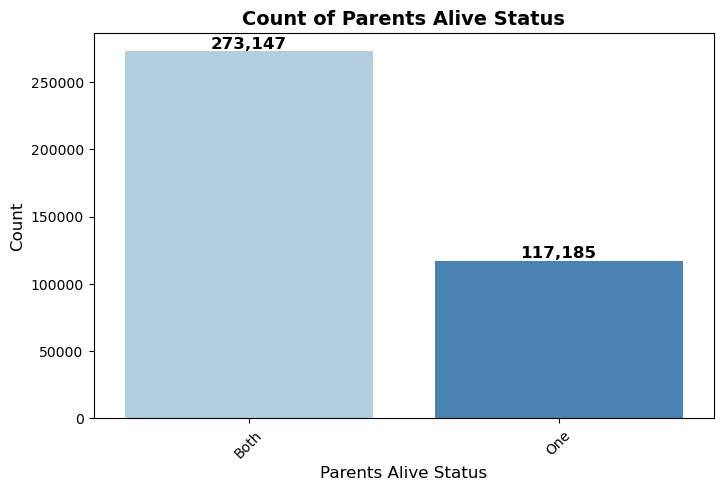

In [13]:
plt.figure(figsize=(8, 5))

# Create count plot with a single color tone
ax = sns.countplot(x='parents_alive_status', data=dreams_df, hue='parents_alive_status', palette='Blues', legend=False)

# Add exact count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',  # Format number with commas
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize labels and title
plt.title("Count of Parents Alive Status", fontsize=14, fontweight='bold')
plt.xlabel("Parents Alive Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()


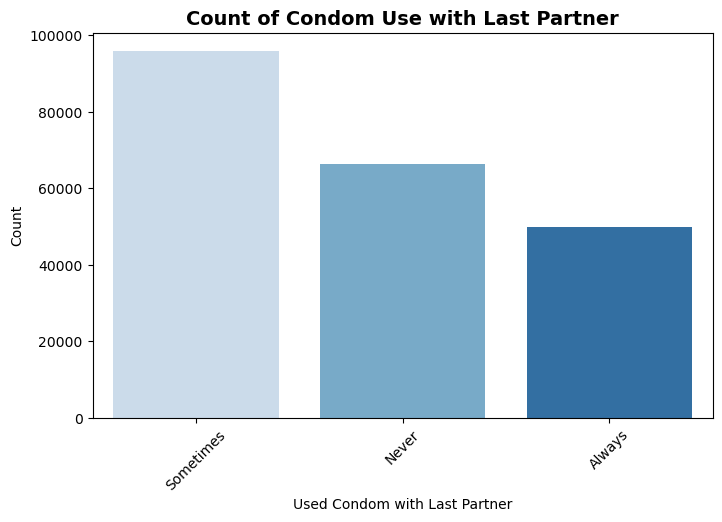

In [14]:
plt.figure(figsize=(8, 5))

sns.countplot(x='used_condom_with_last_partner', 
              data=dreams_df, 
              hue='used_condom_with_last_partner', 
              palette='Blues', 
              legend=False)

plt.title("Count of Condom Use with Last Partner", fontsize=14, fontweight='bold')
plt.xlabel("Used Condom with Last Partner")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

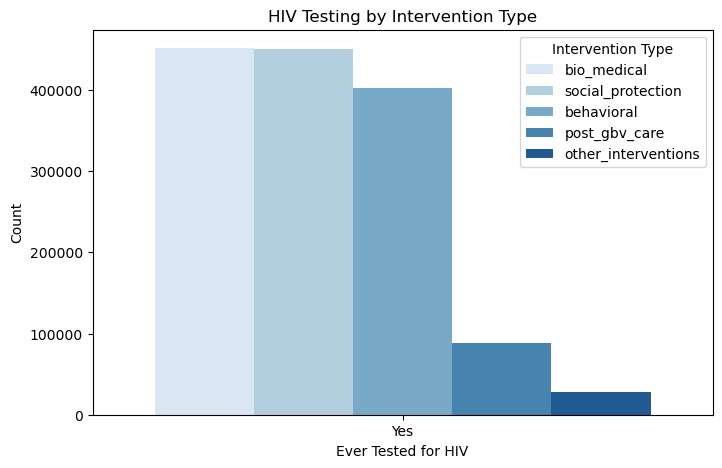

In [15]:
plt.figure(figsize=(8, 5))
intervention_cols = ["bio_medical", "social_protection", "behavioral", "post_gbv_care", "other_interventions"]
df_intervention = dreams_df.melt(id_vars=['ever_tested_for_hiv'], value_vars=intervention_cols, var_name="Intervention_Type", value_name="Received")

# Filter only those who received an intervention
df_intervention = df_intervention[df_intervention['Received'] == 1]

sns.countplot(x="ever_tested_for_hiv", hue="Intervention_Type", data=df_intervention, palette="Blues")
plt.xlabel("Ever Tested for HIV")
plt.ylabel("Count")
plt.title("HIV Testing by Intervention Type")
plt.legend(title="Intervention Type", bbox_to_anchor=(1, 1))
plt.show()


#### insights
- A significant number of individuals have been tested for HIV under different intervention types.
- The highest number of tests is observed in bio_medical, social_protection, and behavioral interventions, which dominate the dataset.
- Post-GBV care and other interventions have significantly lower testing numbers compared to other categories.
- Bio-medical and social protection interventions may play a crucial role in encouraging HIV testing, making them valuable in HIV prevention programs.
- Targeted efforts might be needed to increase HIV testing rates in post-GBV care and other intervention categories.

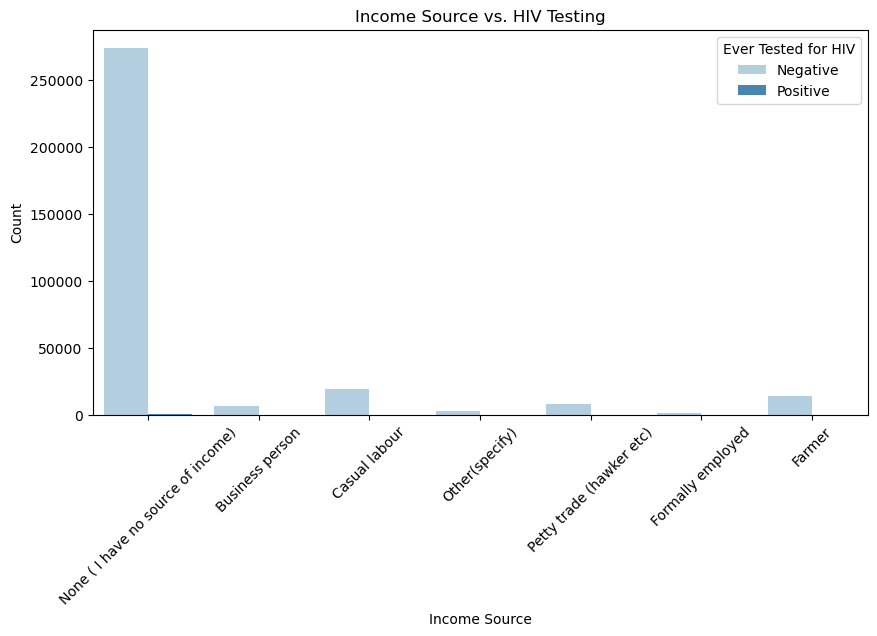

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(x="current_income_source", hue="result", data=dreams_df, palette="Blues")
plt.xticks(rotation=45)
plt.xlabel("Income Source")
plt.ylabel("Count")
plt.title("Income Source vs. HIV Testing")
plt.legend(title="Ever Tested for HIV")
plt.show()

#### insights
- Unemployed individuals dominate the testing population, suggesting effective outreach to financially vulnerable groups.
- Employed and business persons have low representation, indicating possible barriers like time constraints or alternative testing access points.
- Further interventions may be needed to engage employed individuals in regular HIV testing.

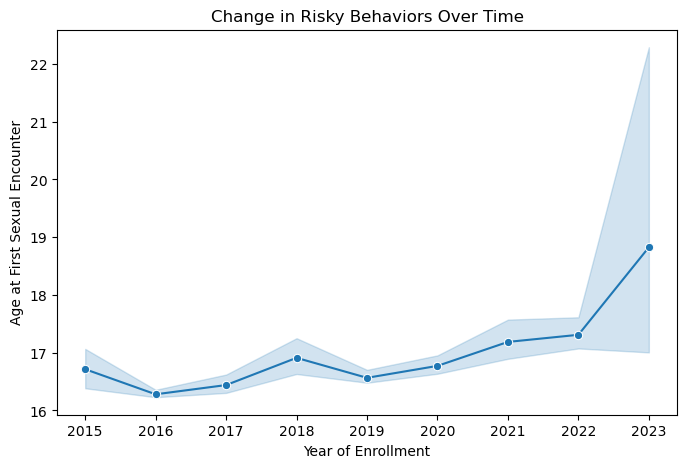

In [17]:
dreams_df['year_of_enrollment'] = pd.to_datetime(dreams_df['date_of_enrollment']).dt.year

plt.figure(figsize=(8, 5))
sns.lineplot(data=dreams_df, x='year_of_enrollment', y='age_at_first_sexual_encounter', marker='o')
plt.xlabel('Year of Enrollment')
plt.ylabel('Age at First Sexual Encounter')
plt.title('Change in Risky Behaviors Over Time')
plt.show()

#### insights
- The age at first sexual encounter appears to have increased gradually from 2016 to 2023.which may indicate Better sexual health education and awareness, possibly due to programs like DREAMS or other community interventions and Increased empowerment and decision-making ability among young people, leading to more informed choices.

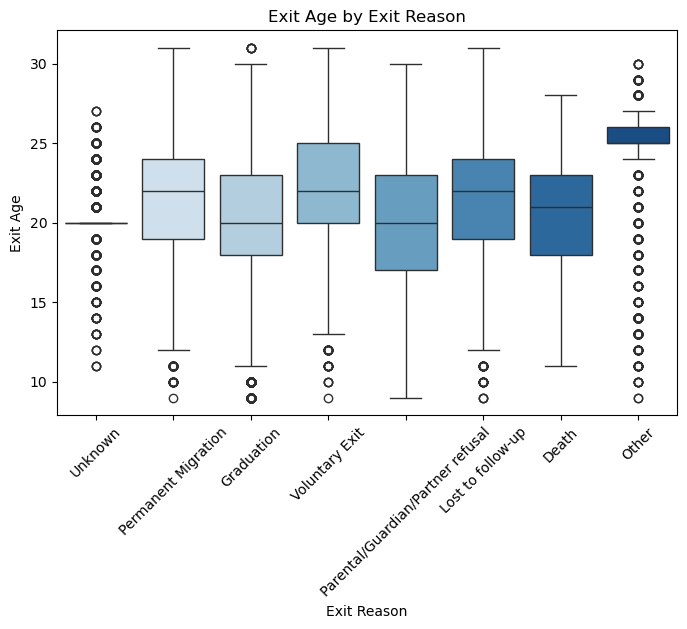

In [18]:
# age distibution by exit reason

plt.figure(figsize=(8, 5))
sns.boxplot(x='exit_reason', y='exit_age', data=dreams_df, hue='exit_reason', palette='Blues', legend=False)
plt.xticks(rotation=45)
plt.xlabel("Exit Reason")
plt.ylabel("Exit Age")     
plt.title("Exit Age by Exit Reason")
plt.show()

#### Insights
- Graduation and Voluntary Exit have a relatively higher median exit age, which suggests participants are completing the program at a later age.
- Early exits (e.g., due to "Lost to follow-up" or "Guardian/Partner refusal") might indicate challenges in retention.
- High variability in some categories suggests different factors influence when participants leave the program.

#### MODELLING

#### Data preprocessing

In [19]:
# Encode target variable (HIV test result)
dreams_df['result'] = dreams_df['result'].map({'Negative': 0, 'Positive': 1})

# Define numerical and categorical columns
categorical_cols = dreams_df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = dreams_df.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('result')  # Remove target variable

# Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# Define full pipeline with SMOTE and Logistic Regression
pipeline = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    LogisticRegression()
)


In [20]:
# Split data into train-test sets
X = dreams_df.drop(columns=['result'])
y = dreams_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [21]:
# Train the pipeline
pipeline.fit(X_train, y_train)



C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age_of_household_head',
                                                   'no_of_people_in_household',
                                                   'no_of_females',
                                                   'no_of_males',
                                                   'no_of_adults',
                                                   'no_of_children',
                                                   'age_at_first_sexual_encounter',
                                                   'bio_medical',
                                                   'social_protection',
                                                   'b...
                                                   'current_income_source',
                                                   'ever_tested_for_hiv',
                                                   'last_test_result',
                                                   'ever_had_sex',
                                                   'has_sexual_partner',
                                                   'age_of_last_partner',
                                                   'used_condom_with_last_partner',
                                                   'dreams_program',
                                                   'dreams_program_other',
                                                   'exit_status', 'exit_reason',
                                                   'intervention_name',
                                                   'intervention_date',
                                                   'exit_reason_other'])])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression())])

In [22]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.966514526463618
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     90940
           1       0.01      0.17      0.02       204

    accuracy                           0.97     91144
   macro avg       0.50      0.57      0.50     91144
weighted avg       1.00      0.97      0.98     91144



##### Explanation:
The model predicts the majority class (0 - Negative) very well. However, accuracy isn't a good metric because our classes are imbalanced.
In precison Out of all predicted positives, only 1% are actually positive.
Recall Out of all actual positive cases, only 17% are correctly identified.

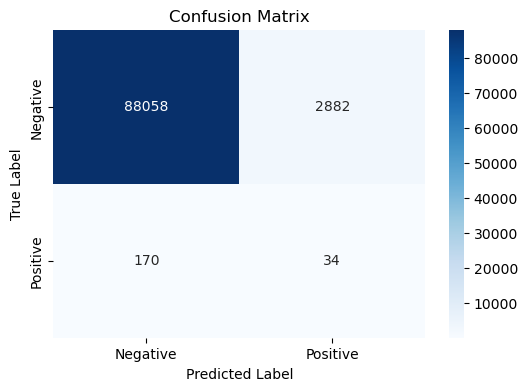

In [23]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)  # Replace y_preds with your model's predictions

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
y.info()

<class 'pandas.core.series.Series'>
Index: 455717 entries, 0 to 455806
Series name: result
Non-Null Count   Dtype
--------------   -----
455717 non-null  int64
dtypes: int64(1)
memory usage: 7.0 MB


##### undersampling the negaive class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter


# Step 1: Under-sample the negative class to match positive class size (1019 samples)
undersample = RandomUnderSampler(sampling_strategy=1019 / 454683, random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

# Now apply undersampling + SMOTE
X_under, y_under = undersample.fit_resample(X, y)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# Step 2: Apply SMOTE to oversample the positive class after under-sampling
Smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1.0 means equal class balance
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# Step 3: Check new class distribution
print(f"New class distribution: {Counter(y_resampled)}")


In [ ]:
X.columns
